<a href="https://colab.research.google.com/github/cuongdaoo/Stock-prediction-using-LSTM-Prophet-and-SARIMA./blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Topic: Stock price prediction of Hoa Phat Group Stock Company (HOSE:HPG)

**Objective**: Improve and develop a model to accurately forecast future stock price trends based on historical and economic factors, helping investors make effective buying and selling decisions, optimize profits and manage risks.\
**Scope:** Price and volume data of HPG stock - HOSE (Hoa Phat Group) from January 1, 2019 - April 1, 2024.\
**Applicable model:**
* Prophet: A time series forecasting model developed by Facebook, designed to be user-friendly and effective for data with seasonal trends and cycles. Prophet is flexible, handles missing data well, and is good at modeling long-term trends and outliers.

* SARIMA (Seasonal ARIMA): An extension of the ARIMA (AutoRegressive Integrated Moving Average) model, incorporating a seasonal component to handle cyclic data. SARIMA combines autoregressive, moving average, and differencing terms, along with seasonal factors for forecasting.

* LSTM (Long Short-Term Memory): A type of deep recurrent neural network (RNN) used for time series data. LSTM excels at retaining both long-term and short-term dependencies, making it effective for forecasting complex and nonlinear sequences.






#Importing library

Cài đặt các thư viện với cú pháp: *!pip install library_name*  
Các thư viện sử dụng: pandas, numpy, matplotlib, plotly, vnstock, scikit-learn, prophet, pdsarima, keras, statsmodels.  

In [1]:
!pip install pandas numpy matplotlib plotly vnstock scikit-learn prophet pmdarima keras statsmodels

In [51]:
import pandas as pd
import numpy as np
import vnstock as vn
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go

# Prophet
from prophet.plot import plot_plotly
from prophet import Prophet

# LSTM
import matplotlib.pyplot as plt # Plotting a graph
from sklearn.preprocessing import MinMaxScaler # Normalizing the data

#Layers to build the model
from keras.models import Sequential # Input
from keras.layers import LSTM # Dependent learning
from keras.layers import Dense # Output
from keras.layers import Dropout # Regularization

# Checking the model's accuracy
from sklearn.metrics import r2_score # Measure r2 score
from sklearn.metrics import mean_absolute_error # Measure mean absolute error
from sklearn.metrics import mean_absolute_percentage_error # Measure % mean absolute error
from sklearn.metrics import mean_squared_error # Measures the mean squared error
from statsmodels.tools.eval_measures import rmse # Measures the square root of the mean squared error

# SARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
# Error evaluation function
def evaluate_predictions(valid, predict):
    result = {}
    result['R^2'] = r2_score(valid, predict)
    result['MAE'] = mean_absolute_error(valid, predict)
    result['MAPE'] = mean_absolute_percentage_error(valid, predict)
    result['MSE'] = mean_squared_error(valid, predict)
    result['RMSE'] = rmse(valid, predict)

    result_df = pd.DataFrame(result, index=[0])

    return result_df

#Processing data

## **Connect to the stock exchange, download data and load into the program..**

The dataset is the price and volume data of the stock code HPG starting from 01-01-2019 to 01-04-2024\
The reason for choosing such a time period is because:
During this period, there were 3 phases: **down-trend, sideway, uptrend**.\
Thus, the data will cover the main stages of the stock market, helping the model predict more accurately under different conditions.\
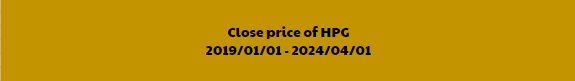

In [4]:
#Loading data for forecasting process starting from January 1, 2019 to April 1, 2024 of HPG stock
df = vn.stock_historical_data(symbol="HPG", start_date="2019-01-01", end_date="2024-04-01", resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
# Format 'YYYY-MM-DD' for date column
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,open,high,low,close,volume,ticker
0,2019-01-02,9850,10030,9820,9820,4196210,HPG
1,2019-01-03,9800,9850,9400,9400,6877510,HPG
2,2019-01-04,9370,9560,9150,9460,5841290,HPG
3,2019-01-07,9650,9670,9290,9350,2488920,HPG
4,2019-01-08,9370,9400,9150,9190,3150620,HPG


##Data statistics and data description


In [5]:
# Summary information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1311 non-null   datetime64[ns]
 1   open    1311 non-null   int64         
 2   high    1311 non-null   int64         
 3   low     1311 non-null   int64         
 4   close   1311 non-null   int64         
 5   volume  1311 non-null   int64         
 6   ticker  1311 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 71.8+ KB


**High**: highest selling price of the day

**Low**: lowest selling price of the day

**Open**: opening price

**Close**: closing price

**Volume**: trading volume (volume) is the number of shares traded during the day

In [6]:
# Description of data
print("\nDescription of data:")
df.describe()


Description of data:


,time,open,high,low,close,volume
count,1311,1311.000000,1311.000000,1311.000000,1311.000000,1.311000e+03
mean,2021-08-17 17:22:22.791761920,19940.883295,20216.497330,19667.842105,19925.906941,1.877064e+07
min,2019-01-02 00:00:00,6340.000000,6920.000000,6320.000000,6710.000000,1.213930e+06
25%,2020-04-28 12:00:00,10755.000000,10930.000000,10635.000000,10800.000000,9.275430e+06
50%,2021-08-17 00:00:00,19730.000000,20000.000000,19460.000000,19680.000000,1.705710e+07
75%,2022-12-06 12:00:00,25550.000000,25820.000000,25295.000000,25590.000000,2.544360e+07
max,2024-04-01 00:00:00,39910.000000,40180.000000,39560.000000,39910.000000,9.965880e+07
std,NaN,8863.870116,8968.695888,8745.248512,8839.261196,1.282915e+07


*The table above describes the stock metrics, including the number, mean, standard deviation, minimum, 25%, 50%, 75%, and maximum values ​​for the opening, high, low, closing, and trading volume prices*

**Count**: The number of data available for each column.

**Mean**: The average value of the data.

Std (Standard Deviation): The standard deviation, which represents the dispersion of the data from the mean.

**Min (Minimum)**: The smallest value in the data set.

**25%**: The value at the 25th percentile, meaning that 25% of the data has a value lower than or equal to this value.

**50%**: The median value, where 50% of the data has a value lower than or equal to this value.

**75%**: The value at the 75th percentile, meaning that 75% of the data has a value less than or equal to this value.

**Max (Maximum)**: The largest value in the data set.

## Cleaning data

In [7]:
# Check initial data
print("Initial data:")
df.head()

Initial data:


,time,open,high,low,close,volume,ticker
0,2019-01-02,9850,10030,9820,9820,4196210,HPG
1,2019-01-03,9800,9850,9400,9400,6877510,HPG
2,2019-01-04,9370,9560,9150,9460,5841290,HPG
3,2019-01-07,9650,9670,9290,9350,2488920,HPG
4,2019-01-08,9370,9400,9150,9190,3150620,HPG


In [8]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove rows with missing data
df = df.dropna()

# Convert data types
df['volume'] = df['volume'].astype(int)

# Check for 'N/A' value
df.isnull().sum()

# Check for 'N/A' value
df.isnull().sum()

,0
time,0
open,0
high,0
low,0
close,0
volume,0
ticker,0


In [9]:
# Check data again after cleaning
print("\nData after cleaning:")
df.head()


Data after cleaning:


,time,open,high,low,close,volume,ticker
0,2019-01-02,9850,10030,9820,9820,4196210,HPG
1,2019-01-03,9800,9850,9400,9400,6877510,HPG
2,2019-01-04,9370,9560,9150,9460,5841290,HPG
3,2019-01-07,9650,9670,9290,9350,2488920,HPG
4,2019-01-08,9370,9400,9150,9190,3150620,HPG


In [10]:
#Create a data table containing only time and close columns
df1= df.drop(['open', 'high', 'low', 'volume', 'ticker'], axis = 'columns')
# Format 'YYYY-MM-DD' for date column
df1['time'] = pd.to_datetime(df1['time'])
#Đặt cột 'time' làm index
#df1.set_index('time', inplace=True)
#Display the first 5 lines of the newly created data
df1.head()

,time,close
0,2019-01-02,9820
1,2019-01-03,9400
2,2019-01-04,9460
3,2019-01-07,9350
4,2019-01-08,9190


#Applying model

Building a predictive model using Part 1 dataset and performing predictive evaluation using Part 2 dataset

- Dataset from 01/01/2019 to 01/04/2024 of Hoa Phat Group (HPG) stock
- Divide the dataset into 2 parts:

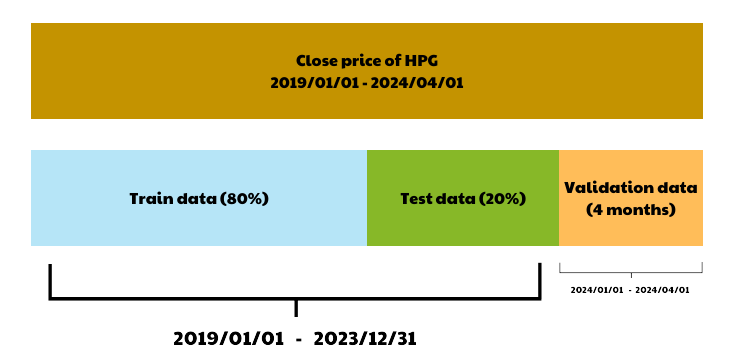

Split data

In [11]:
data_p1 = df1[(df1['time'] >= '2019-01-01') & (df1['time'] <= '2023-12-31')]
train_data = data_p1[:int(len(data_p1)*0.8)] # Train Data part 1
test_data = data_p1[int(len(data_p1)*0.8):] # Test Data part 1
data_p2 = df1[(df1['time'] >= '2024-01-01')] #validation data

# Prophet

In [12]:
#Copy data
df_prophet=df1.copy()
df_prophet.head()

,time,close
0,2019-01-02,9820
1,2019-01-03,9400
2,2019-01-04,9460
3,2019-01-07,9350
4,2019-01-08,9190


##Modeling

In [13]:
# Convert the model to Prophet's predictive model
df_prophet.columns = ['ds','y']

In [14]:
# Time data transformation required for prediction
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet.tail()

,ds,y
1306,2024-03-26,27770
1307,2024-03-27,27820
1308,2024-03-28,27770
1309,2024-03-29,27500
1310,2024-04-01,27360


In [15]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1311 non-null   datetime64[ns]
 1   y       1311 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 20.6 KB


<Axes: xlabel='ds'>

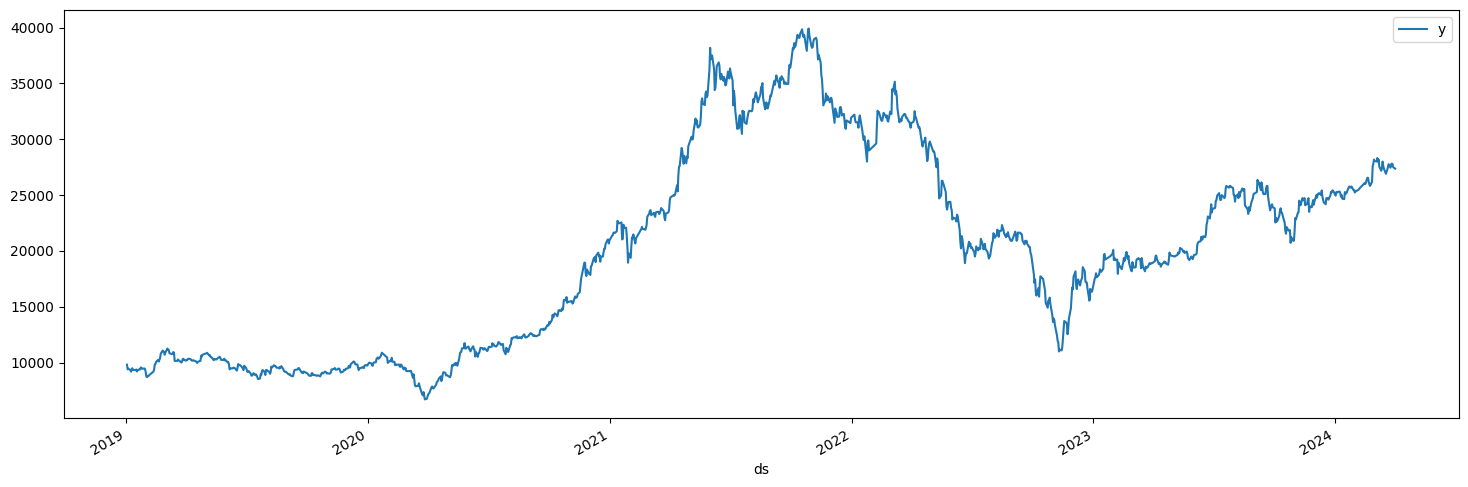

In [16]:
#Data chart
df_prophet.plot(x='ds',y='y',figsize=(18,6))

Fit model

In [17]:
# !!! The prophet model does not require data to be trained to be able to data
# When we 'FIT' the data model, it automatically understands the data taken from HPG's vnstocks DataFrame
# Almost does not skip most of the steps of normalization, model building like other models

prophet = Prophet(daily_seasonality = True)
prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxya22d9t/pi6qht7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxya22d9t/jv7s7nc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8830', 'data', 'file=/tmp/tmpxya22d9t/pi6qht7r.json', 'init=/tmp/tmpxya22d9t/jv7s7nc4.json', 'output', 'file=/tmp/tmpxya22d9t/prophet_modelob48mrjz/prophet_model-20241010172259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


###Model Evaluation

In [18]:
#Forecast for the first 4 months of 2024 corresponding to data_p2:
future_dates = prophet.make_future_dataframe(periods=len(data_p2))
predictions = prophet.predict(future_dates)

In [19]:
# Display forcasting table
predictions[['ds', 'yhat']].iloc[-len(data_p2):]


,ds,yhat
1310,2024-04-02,27455.172135
1311,2024-04-03,27559.521995
1312,2024-04-04,27615.129388
1313,2024-04-05,27645.819718
1314,2024-04-06,27623.606230
1315,2024-04-07,27691.161707
1316,2024-04-08,27770.402004
1317,2024-04-09,27893.961683
1318,2024-04-10,28024.009282
1319,2024-04-11,28101.237414


In [20]:
#Display data chart
plot_plotly(prophet,predictions)

In [21]:
evaluate_prophet = evaluate_predictions(data_p2['close'], predictions['yhat'].iloc[-len(data_p2):])
print("Prophet model evaluation resultst:\n")
evaluate_prophet

Prophet model evaluation resultst:



,R^2,MAE,MAPE,MSE,RMSE
0,-4.7165,2666.463405,0.101897,7.490235e+06,2736.829365


#LSTM

## Modeling

In [22]:
data_lstm = df1

In [23]:
scaler = MinMaxScaler()
data_lstm['close'] = scaler.fit_transform(data_lstm[['close']])

In [24]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [25]:
data_p1 = df1[(df1['time'] >= '2019-01-01') & (df1['time'] <= '2023-12-31')] # Data phần 1
data_p2 = df1[(df1['time'] >= '2024-01-01')] # Data phần 2
train_data = data_p1[:int(len(data_p1)*0.8)] # Train Data phần 1
test_data = data_p1[int(len(data_p1)*0.8):]

trainX, trainY = create_dataset(train_data['close'].values, 30) # Sử dụng vòng lặp là look_back=30
testX, testY = create_dataset(test_data['close'].values, 30)
assesX, assesY = create_dataset(data_p2['close'].values, 30) # assessment  data (Dữ liệu đánh giá 4 tháng cuối)


In [26]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
assesX = np.reshape(assesX, (assesX.shape[0], assesX.shape[1], 1))

Attention: X_train will have the shape (n_sample, time_step, features), meaning that each sample will now take the form of a time series (like a sequence of consecutive actions combined to form a meaningful movement). With this shape, it fits the default input_shape required by the LSTM layer in Keras.


1. **Create the Sequential model**
   ```python
   lstm_model = Sequential()
   ```
   - This initializes a **Sequential** model in Keras, which allows for stacking layers in a linear fashion from input to output.

2. **Add the first LSTM layer**
   ```python
   lstm_model.add(LSTM(units=128, input_shape=(30,1), return_sequences=True))
   ```
   - **units=128**: The LSTM layer contains 128 units (neurons) that can learn and store relationships in the time series data.
   - **input_shape=(30,1)**: The input consists of 30 time steps with 1 feature at each step.
   - **return_sequences=True**: This makes the layer return the full sequence of outputs instead of just the last output, which is necessary since more LSTM layers are added.

3. **Add the second LSTM layer**
   ```python
   lstm_model.add(LSTM(units=1))
   ```
   - **units=1**: This LSTM layer has 1 unit, typically used to summarize the input sequence and generate the final output. No need for `return_sequences` since it's the final LSTM layer.

4. **Add Dropout**
   ```python
   lstm_model.add(Dropout(0.5))
   ```
   - **Dropout(0.5)**: Dropout randomly drops 50% of the neurons during training to reduce overfitting, ensuring the model doesn't become reliant on a small set of neurons.

5. **Add the Dense layer (fully connected layer)**
   ```python
   lstm_model.add(Dense(1))
   ```
   - **Dense(1)**: A fully connected layer with 1 unit, producing the final prediction, which is a single value for the time series forecasting problem.

6. **Compile the model**
   ```python
   lstm_model.compile(loss='mean_absolute_error', optimizer='adam')
   ```
   - **loss='mean_absolute_error'**: The loss function used is **Mean Absolute Error** (MAE), which measures the difference between predicted and actual values.
   - **optimizer='adam'**: The **Adam** optimizer is used to optimize the model, a well-known algorithm for fast and effective training.

7. **Summarize the model**
   ```python
   model.summary()
   ```
   - Displays a summary of the model's architecture, showing the layers, number of parameters, and output shapes.

8. **Train the model**
   ```python
   model.fit(trainX, trainY, epochs=100, batch_size=50, verbose=2)
   ```
   - **trainX** and **trainY** are the training inputs and labels.
   - **epochs=100**: The model will train for 100 epochs (iterations over the entire dataset).
   - **batch_size=50**: The training data is divided into batches of 50 samples to update the model’s weights.
   - **verbose=2**: Provides a concise output of the training process.

This model uses the LSTM architecture to learn and predict time series data, with techniques to prevent overfitting and optimize the learning process.

In [27]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(30, 1)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=100, batch_size=50, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 - 3s - 155ms/step - loss: 0.0271
Epoch 2/100
20/20 - 1s - 55ms/step - loss: 0.0025
Epoch 3/100
20/20 - 2s - 84ms/step - loss: 0.0011
Epoch 4/100
20/20 - 2s - 83ms/step - loss: 9.4183e-04
Epoch 5/100
20/20 - 1s - 46ms/step - loss: 9.0214e-04
Epoch 6/100
20/20 - 1s - 59ms/step - loss: 8.8717e-04
Epoch 7/100
20/20 - 1s - 63ms/step - loss: 8.8767e-04
Epoch 8/100
20/20 - 1s - 63ms/step - loss: 8.0184e-04
Epoch 9/100
20/20 - 1s - 65ms/step - loss: 7.7160e-04
Epoch 10/100
20/20 - 1s - 43ms/step - loss: 7.4691e-04
Epoch 11/100
20/20 - 1s - 63ms/step - loss: 7.2009e-04
Epoch 12/100
20/20 - 1s - 62ms/step - loss: 7.5227e-04
Epoch 13/100
20/20 - 1s - 43ms/step - loss: 6.8641e-04
Epoch 14/100
20/20 - 2s - 79ms/step - loss: 6.8722e-04
Epoch 15/100
20/20 - 2s - 94ms/step - loss: 6.4197e-04
Epoch 16/100
20/20 - 1s - 56ms/step - loss: 6.3690e-04
Epoch 17/100
20/20 - 1s - 70ms/step - loss: 6.2504e-04
Epoch 18/100
20/20 - 1s - 73ms/step - loss: 6.2600e-04
Epoch 19/100
20/20 - 2s - 98ms

Make predictions on Test Data:

In [28]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


### Test data evaluation

In [29]:
# Error assessment
evaluate_lstm_test = evaluate_predictions(testY, testPredict)
print("LSTM model test set evaluation results:\n")
evaluate_lstm_test

LSTM model test set evaluation results:



,R^2,MAE,MAPE,MSE,RMSE
0,0.962771,365.864757,0.016299,248431.100181,498.428631


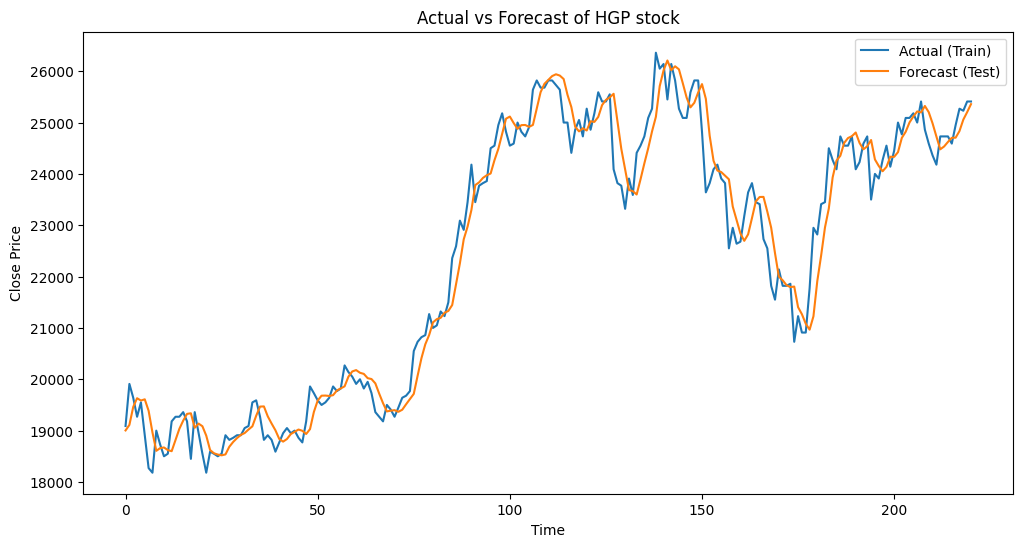

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual (Train)')
plt.plot(testPredict, label='Forecast (Test)')
plt.title('Actual vs Forecast of HGP stock')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

###Model Evaluation

In [32]:
assesPredict = model.predict(assesX)
assesPredict = scaler.inverse_transform(assesPredict)
assesY = scaler.inverse_transform(assesY.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [33]:
# Error assessment
evaluate_lstm = evaluate_predictions(assesY, assesPredict)
print("LSTM model test set evaluation results:\n")
evaluate_lstm

LSTM model test set evaluation results:



,R^2,MAE,MAPE,MSE,RMSE
0,0.401463,390.218034,0.014253,262377.479889,512.227957


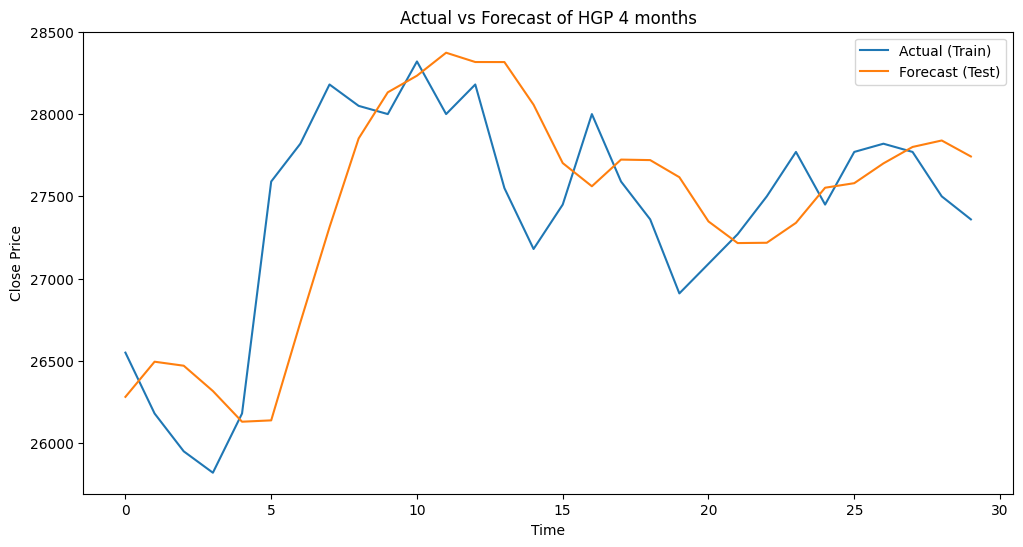

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(assesY, label='Actual (Train)')
plt.plot(assesPredict, label='Forecast (Test)')
plt.title('Actual vs Forecast of HGP 4 months')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#Sarima

In [45]:
#Copy data
data_srm = df[['time', 'close']]

In [46]:
#split data
data_p1 = data_srm[(data_srm['time'] >= '2019-01-01') & (data_srm['time'] <= '2023-12-31')]
data_p2 = data_srm[(data_srm['time'] >= '2024-01-01')]
train_data = data_p1[:int(len(data_p1)*0.8)]
test_data = data_p1[int(len(data_p1)*0.8):]

##Checking the elements

Stationarity in SARIMA

In [47]:
#Convert the close price series to a stationary series by calculating the returns using the first-order differencing of the logarithm.
r_t = np.log(data_srm['close']/data_srm['close'].shift(1)).values.flatten()

#Fill np.nan value with series average
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00078218, -0.04371143,  0.00636269, -0.01169604, -0.01726041])

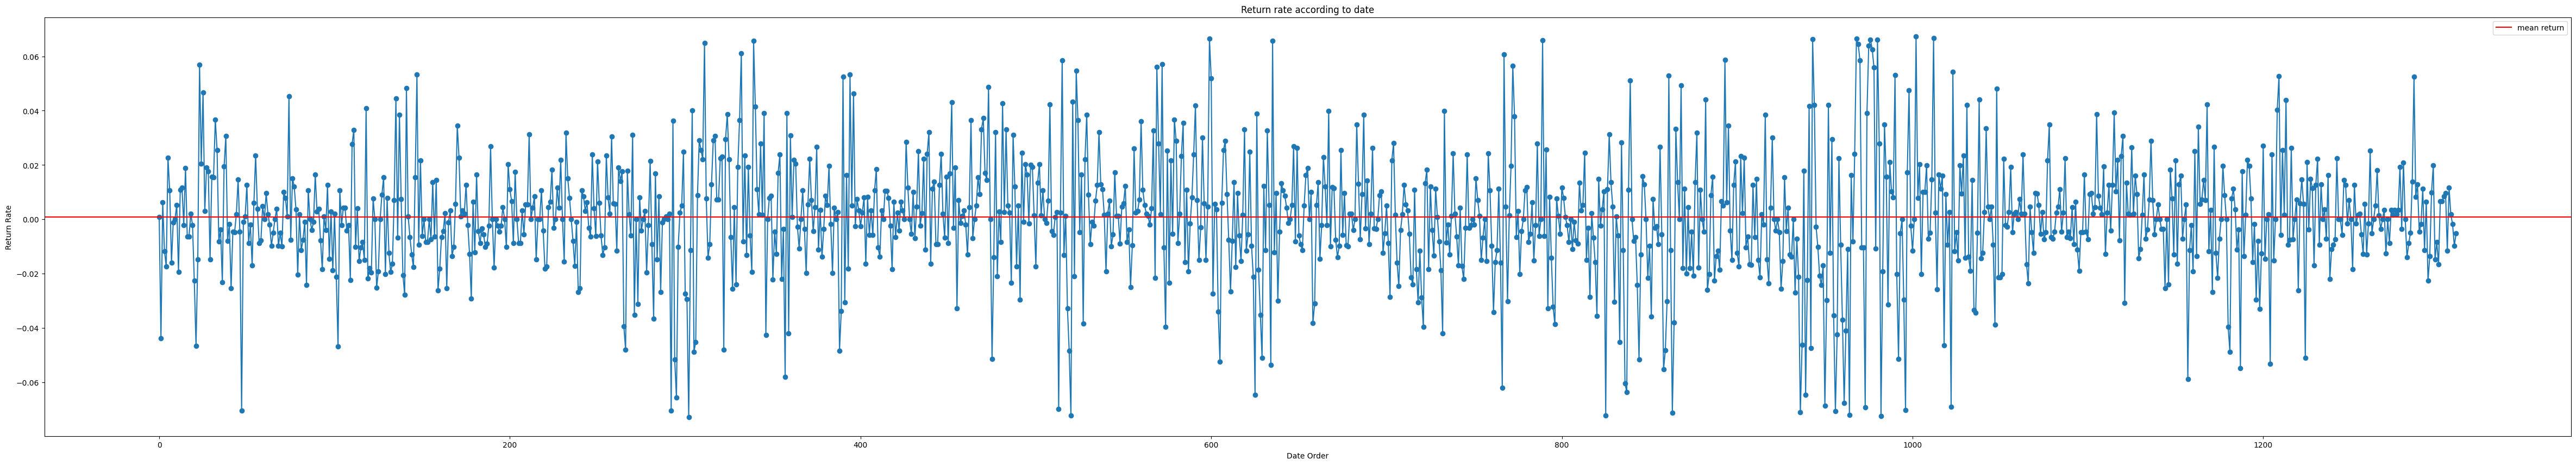

In [48]:
#R_t yield series chart
plt.figure(figsize=(60, 10))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

The plot of the return series $r_t$ shows that it is a random fluctuation in the form of white noise, with a mean close to 0 and constant variance.

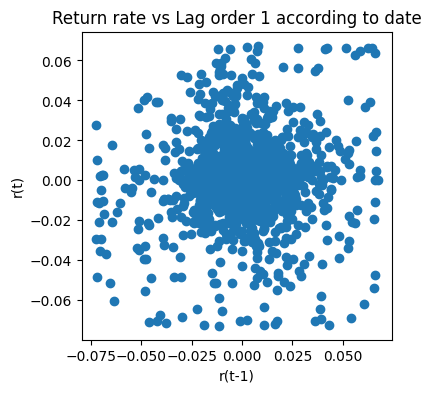

In [49]:
#Plot the sequence r_t against the sequence r_t-1 to see if they are linearly or randomly related
plt.figure(figsize=(4, 4))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

The graph shows that the two series $r_t$ and $r_{t-1}$ are not correlated. Their histogram is a collection of points that do not follow a particular trend.

<ipython-input-52-c891eb1cfde8>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'frequency')

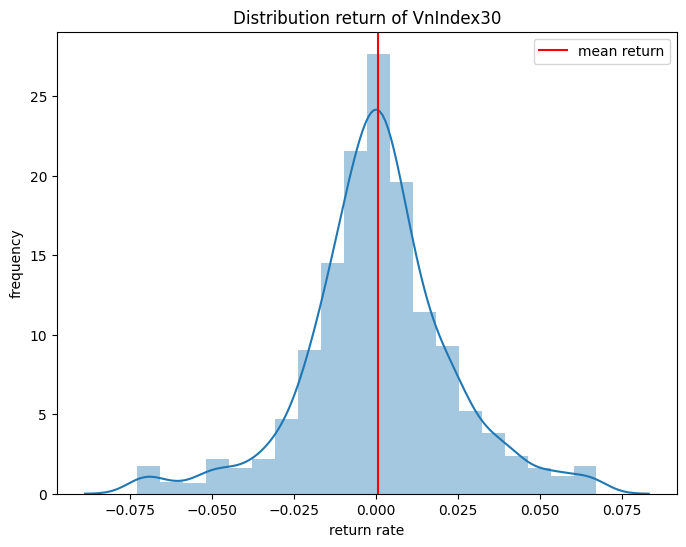

In [52]:
#Plot the probability distribution of the return series.
plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of VnIndex30')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

From the return distribution plot, we observe that the return series appears to follow a normal distribution with an expected value of 0

Test for stationarity


The stationarity of the series \(y_t\) will depend on whether the characteristic equation \(\theta(y) = 1 - \theta L = 0\) has a unit root or not. If the characteristic equation has a unit root, the series \(y_t\) will not be stationary.  
We use the ADF test. The null hypothesis is that the characteristic equation has a unit root. In the case where the p-value < 0.05, we will reject the null hypothesis and accept the alternative hypothesis. Thus, we can affirm that the series does not have a unit root and is stationary.

\begin{cases}
H_0: \phi = 1 \\
H_1: |\phi| < 1
\end{cases}


In [53]:
result_adf = adfuller(r_t)

print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')

for key, value in result_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -33.962170
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568



With a p-value < 0.05, we conclude that we will reject the null hypothesis $ H_0 $. The characteristic equation has no unit root. Therefore, the return series $ r_t $ is stationary.

**Seasonality**

<Axes: >

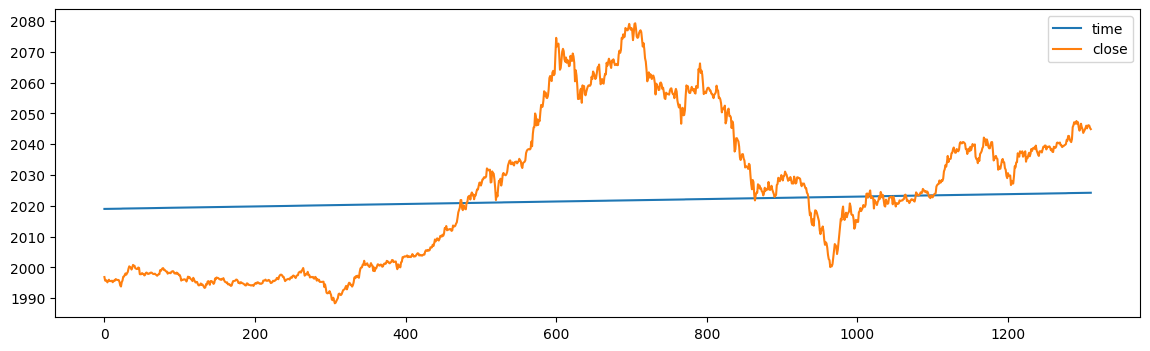

In [54]:
data_srm.plot(figsize=(14, 4))

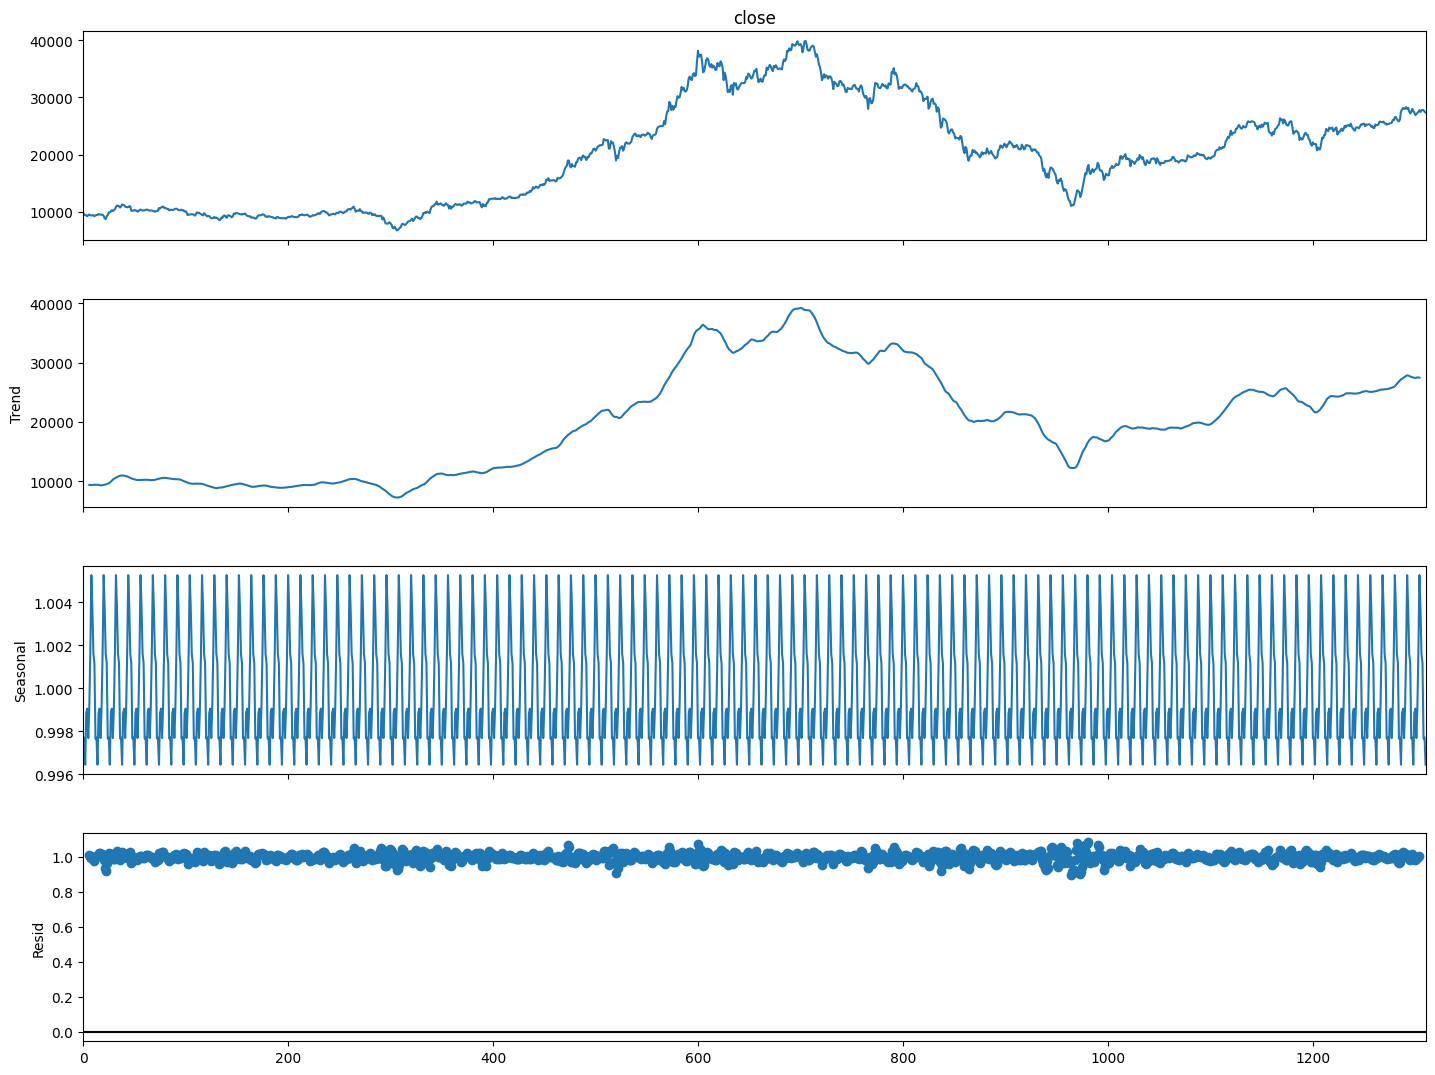

In [57]:
#Extract the components that make up the series
period = 12
result_ssn = seasonal_decompose(data_srm['close'], model='multiplicative', period=period)
fig = result_ssn.plot()
fig.set_size_inches(16, 12)

##Modeling

Examine the properties

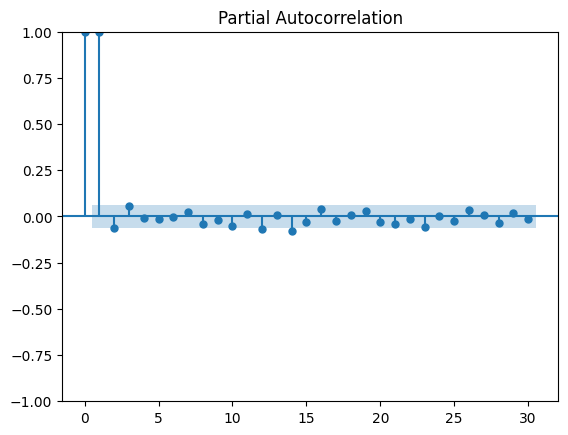

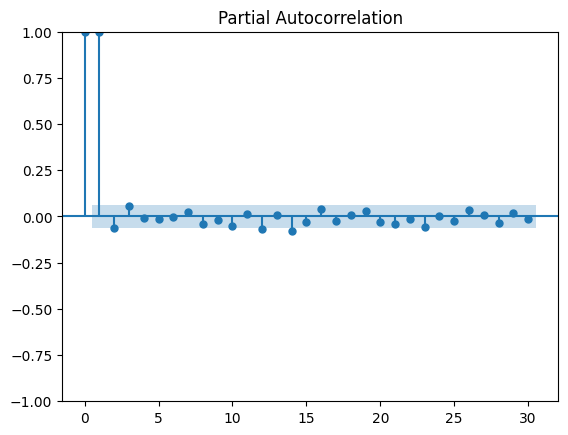

In [59]:
#Partial Autocorrelation Plot
plot_pacf(train_data['close'])

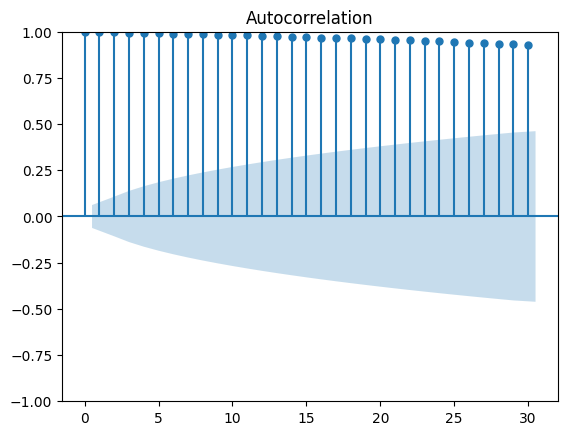

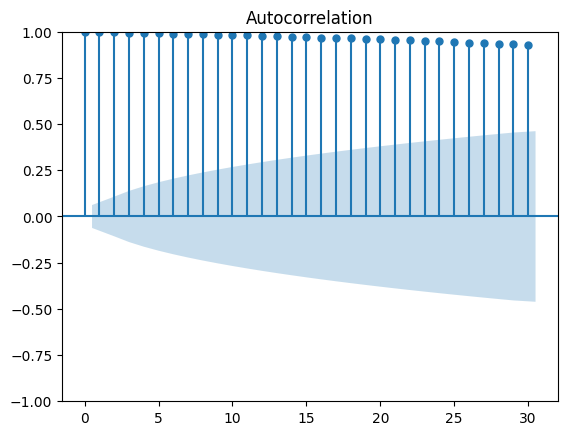

In [61]:
#Autocorrelation Plot
plot_acf(train_data['close'])

In [62]:
best_model = auto_arima(train_data['close'], start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
#Use auto arima function (based on stepwise strategy) to find the best model
print(best_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15692.719, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15401.244, Time=1.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15694.335, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15321.354, Time=3.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.76 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15322.111, Time=0.73 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15310.579, Time=4.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15392.449, Time=1.68 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=15.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=10.95 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=15312.317, Time=4.71 sec
 ARIMA(2,1,1)(2,1,0)[12]             : 

In [63]:
#The best parameter set found is (2,1,0)(2,1,0,12)
#Using the parameter set for sarima_model
sarima_model = SARIMAX(train_data['close'],
                            order=(2, 1, 0),
                            seasonal_order=(2, 1, 0, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
sarima_result = sarima_model.fit()

In [65]:
# Forecasting
forecast = sarima_result.forecast(len(test_data))


fig = go.Figure()
# adding actual data
fig.add_trace(go.Scatter(x=test_data['time'], y=test_data['close'], mode='lines', name='Actual (Train)', line=dict(color='skyblue')))
# Add 30-day forecast data
fig.add_trace(go.Scatter(x=test_data['time'], y=forecast, mode='lines', name='Forecast (Test)', line=dict(color='blue')))
# Layout settings
fig.update_layout(title=f'Hoa Phat Group (HPG) forecast chart',
                xaxis_title='Time',
                yaxis_title='Close Price')

fig.show()

###Test data evaluation

In [66]:
# Error assessment
evaluate_sarima_test = evaluate_predictions(test_data['close'], forecast)
print("Evaluation results of SARIMA model test set:\n")
evaluate_sarima_test

Evaluation results of SARIMA model test set:



,R^2,MAE,MAPE,MSE,RMSE
0,-7.679413,6761.287037,0.297352,6.532162e+07,8082.178857


### Model evaluation

In [68]:
forecast = sarima_result.predict(data_p2.index[0], data_p2.index[-1])
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_p2['time'], y=data_p2['close'], mode='lines', name='Actual (Train)', line=dict(color='skyblue')))
fig.add_trace(go.Scatter(x=data_p2['time'], y=forecast, mode='lines', name='Forecast (Test)', line=dict(color='blue')))
fig.update_layout(title=f'Hoa Phat Group (HPG) forecast chart',
                xaxis_title='Time',
                yaxis_title='Close Price')
fig.show()

In [69]:
# Error assessment
evaluate_sarima = evaluate_predictions(data_p2['close'], forecast)
print("SARIMA model evaluation results:\n")
evaluate_sarima

SARIMA model evaluation results:



,R^2,MAE,MAPE,MSE,RMSE
0,-197.576265,16110.646623,0.610972,2.601912e+08,16130.442339


#Compare

Compare the SARIMA, Prophet, and LSTM models when forecasting data for the last 4 months

In [70]:
print('LSTM:\n',evaluate_lstm)
print('Prophet:\n',evaluate_prophet)
print('SARIMA:\n',evaluate_sarima)

LSTM:
         R^2         MAE      MAPE            MSE        RMSE
0  0.401463  390.218034  0.014253  262377.479889  512.227957
Prophet:
       R^2          MAE      MAPE           MSE         RMSE
0 -4.7165  2666.463405  0.101897  7.490235e+06  2736.829365
SARIMA:
           R^2           MAE      MAPE           MSE          RMSE
0 -197.576265  16110.646623  0.610972  2.601912e+08  16130.442339


The conclusion sheds light on the effectiveness of the method of forecasting the future price of Hoa Phat Group shares using time series forecasting methods such as Facebook Prophet, SARIMA and LSTM. The experimental results showed that among these methods, LSTM gave the best performance, followed by Prophet and finally SARIMA.